In [ ]:
!pip install -q SimpleITK

In [9]:
# RFMiD dataset paths (auto-discover under /kaggle/input)
from pathlib import Path
import pandas as pd

FEAT_DIR = "/kaggle/working/rfmid_extracted_features"
LABELS_CSV_PATH = "/kaggle/working/rfmid_labels.csv"

# 1) find RFMiD_Validation_Labels.csv
hits = list(Path("/kaggle/input").rglob("RFMiD_Validation_Labels.csv"))
if not hits:
    raise FileNotFoundError("Could not find RFMiD_Validation_Labels.csv under /kaggle/input. Make sure dataset is attached.")
rfmid_csv = hits[0]
print("Using labels:", rfmid_csv)

# 2) locate Validation image folder (from your screenshot)
# It's usually .../Evaluation_Set/Evaluation_Set/Validation
val_dirs = [p for p in rfmid_csv.parents if p.name.lower() == "validation"]
if val_dirs:
    VAL_IMG_DIR = val_dirs[0]
else:
    # robust search
    val_hits = list(Path("/kaggle/input").rglob("Evaluation_Set/Evaluation_Set/Validation"))
    if not val_hits:
        val_hits = list(Path("/kaggle/input").rglob("*/Validation"))
    if not val_hits:
        raise FileNotFoundError("Could not find Validation folder under /kaggle/input.")
    VAL_IMG_DIR = val_hits[0]

print("Using validation images dir:", VAL_IMG_DIR)

# 3) read label CSV
df = pd.read_csv(rfmid_csv)

# RFMiD usually has an ID column like "ID" (sometimes "Image" etc.)
id_col = next((c for c in df.columns if c.lower() in ["id", "image", "image_id"]), None)
if id_col is None:
    # fallback: first column
    id_col = df.columns[0]

df["image_id"] = df[id_col].astype(str)

# 4) choose a target label column (binary)
# RFMiD has many columns; pick one that exists.
# Common: "DR" (Diabetic Retinopathy) exists in RFMiD.
LABEL_COL = "DR" if "DR" in df.columns else None
if LABEL_COL is None:
    # fallback: first non-ID column
    label_candidates = [c for c in df.columns if c != id_col]
    if not label_candidates:
        raise ValueError("No label columns found in RFMiD CSV.")
    LABEL_COL = label_candidates[0]

print("Using LABEL_COL:", LABEL_COL)

df["label"] = pd.to_numeric(df[LABEL_COL], errors="coerce").fillna(0).astype(int)

# 5) map image_id -> img_path (try common extensions)
def find_img_path(image_id: str):
    for ext in [".png", ".jpg", ".jpeg", ".tif", ".tiff"]:
        p = VAL_IMG_DIR / f"{image_id}{ext}"
        if p.exists():
            return str(p)
    # sometimes IDs include extension already
    p = VAL_IMG_DIR / image_id
    if p.exists():
        return str(p)
    return None

df["img_path"] = df["image_id"].map(find_img_path)
df = df[df["img_path"].notna()].copy()

# 6) fold column (single fold = 0)
df["fold"] = 0

# keep only what extractor needs
out_df = df[["image_id", "img_path", "label", "fold"]].drop_duplicates().reset_index(drop=True)
out_df.to_csv(LABELS_CSV_PATH, index=False)

print(f"Saved {LABELS_CSV_PATH} with {len(out_df)} rows.")
print("Label counts:", out_df["label"].value_counts().to_dict())

Using labels: /kaggle/input/datasets/andrewmvd/retinal-disease-classification/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv
Using validation images dir: /kaggle/input/datasets/andrewmvd/retinal-disease-classification/Evaluation_Set/Evaluation_Set/Validation
Using LABEL_COL: DR
Saved /kaggle/working/rfmid_labels.csv with 640 rows.
Label counts: {0: 508, 1: 132}


In [10]:
from pathlib import Path

_SCRIPT = r'''
"""Offline patch-based FPN feature extraction for RFMiD (tile image -> extract C4/C5 per patch)."""

import argparse, sys
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
import torchvision.transforms.functional as TF
from PIL import Image
import pandas as pd
import h5py

# ----------------------------
# Backbone + FPN (same spirit as your PI-CAI script)
# ----------------------------
class FeaturePyramidNetwork(nn.Module):
    def __init__(self, in_channels_list, out_channels, top_down_pathway=True, upsample_method="nearest"):
        super().__init__()
        self.top_down_pathway = top_down_pathway
        self.upsample_method = upsample_method

        self.inner_blocks = nn.ModuleDict({
            f"inner_block_{idx}": nn.Conv2d(in_ch, out_channels, kernel_size=1, bias=True)
            for idx, in_ch in enumerate(in_channels_list)
        })
        self.layer_blocks = nn.ModuleDict({
            f"layer_block_{idx}": nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True)
            for idx in range(len(in_channels_list))
        })

    def forward(self, selected_fmaps):
        # selected_fmaps: [C4, C5] (we’ll name them like that)
        last_inner = self.inner_blocks["inner_block_1"](selected_fmaps[-1])
        results = [self.layer_blocks["layer_block_1"](last_inner)]

        if self.top_down_pathway:
            inner_lateral = self.inner_blocks["inner_block_0"](selected_fmaps[0])
            feat_shape = inner_lateral.shape[-2:]
            inner_top_down = F.interpolate(last_inner, size=feat_shape, mode=self.upsample_method)
            last_inner = inner_lateral + inner_top_down
            results.insert(0, self.layer_blocks["layer_block_0"](last_inner))
        else:
            inner_lateral = self.inner_blocks["inner_block_0"](selected_fmaps[0])
            results.insert(0, self.layer_blocks["layer_block_0"](inner_lateral))

        return results[0], results[1]  # (C4-like, C5-like)

class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        r = resnet18(weights=None)
        self.conv1, self.bn1, self.relu = r.conv1, r.bn1, r.relu
        self.maxpool, self.layer1, self.layer2 = r.maxpool, r.layer1, r.layer2
        self.layer3, self.layer4 = r.layer3, r.layer4

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        c4 = self.layer3(x)
        c5 = self.layer4(c4)
        return c4, c5

class Encoder(nn.Module):
    def __init__(self, feat_dim=256):
        super().__init__()
        self.backbone = Backbone()
        self.fpn = FeaturePyramidNetwork(in_channels_list=[256, 512], out_channels=feat_dim, top_down_pathway=True)

    def forward(self, x):
        c4, c5 = self.backbone(x)
        f4, f5 = self.fpn([c4, c5])
        return f4, f5

# ----------------------------
# Patching utils
# ----------------------------
def pad_to_grid(img_t, patch_size, stride):
    """
    Pad image so that sliding-window with given stride covers border nicely.
    img_t: [3,H,W] float
    """
    _, H, W = img_t.shape
    if H < patch_size:
        pad_h = patch_size - H
    else:
        rem = (H - patch_size) % stride
        pad_h = (stride - rem) % stride
    if W < patch_size:
        pad_w = patch_size - W
    else:
        rem = (W - patch_size) % stride
        pad_w = (stride - rem) % stride

    # pad bottom/right only (keeps coords simple)
    if pad_h > 0 or pad_w > 0:
        img_t = F.pad(img_t, (0, pad_w, 0, pad_h), mode="constant", value=0.0)
    return img_t, (H, W)

def extract_patches(img_t, patch_size, stride, bg_thresh=0.05):
    """
    img_t: [3,H,W] float in [0,1]
    returns:
      patches: [N,3,patch,patch]
      coords:  [N,2] (y,x) in ORIGINAL (pre-pad) coordinate space (top-left)
      padded_hw: (Hp, Wp)
      orig_hw: (H, W)
    """
    img_t, (H0, W0) = pad_to_grid(img_t, patch_size, stride)
    _, H, W = img_t.shape

    ys = list(range(0, max(1, H - patch_size + 1), stride))
    xs = list(range(0, max(1, W - patch_size + 1), stride))

    # ensure border coverage
    if ys[-1] != H - patch_size:
        ys.append(H - patch_size)
    if xs[-1] != W - patch_size:
        xs.append(W - patch_size)

    patches = []
    coords = []

    for y in ys:
        for x in xs:
            p = img_t[:, y:y+patch_size, x:x+patch_size]

            # skip mostly-dark background patches (fundus has black borders)
            nz_ratio = (p > 0.05).float().mean().item()
            if nz_ratio < bg_thresh:
                continue

            patches.append(p)
            coords.append([y, x])

    if len(patches) == 0:
        # fallback: center patch
        y = max(0, (H - patch_size) // 2)
        x = max(0, (W - patch_size) // 2)
        patches = [img_t[:, y:y+patch_size, x:x+patch_size]]
        coords = [[y, x]]

    patches = torch.stack(patches, dim=0)  # [N,3,P,P]
    coords = np.array(coords, dtype=np.int32)
    return patches, coords, (H, W), (H0, W0)

def load_image_rgb(path):
    im = Image.open(path).convert("RGB")
    # -> float tensor [3,H,W] in [0,1]
    t = TF.to_tensor(im)
    return t

# ----------------------------
# Main
# ----------------------------
def main(argv=None):
    argv = argv or sys.argv[1:]
    p = argparse.ArgumentParser()
    p.add_argument("--labels_csv", required=True, help="rfmid_labels.csv with columns image_id,img_path,label,split")
    p.add_argument("--feat_dir", default="/kaggle/working/rfmid_extracted_features")
    p.add_argument("--patch_size", type=int, default=224)
    p.add_argument("--stride", type=int, default=224)  # set smaller for overlap, e.g. 112
    p.add_argument("--feat_dim", type=int, default=256)
    p.add_argument("--device", default="cuda")
    p.add_argument("--batch_patches", type=int, default=64)
    p.add_argument("--bg_thresh", type=float, default=0.05)
    args = p.parse_args(argv)

    labels_csv = Path(args.labels_csv)
    feat_dir = Path(args.feat_dir)
    ms_dir = feat_dir / "multi_scale"
    ms_dir.mkdir(parents=True, exist_ok=True)

    df = pd.read_csv(labels_csv)
    if "image_id" not in df.columns or "img_path" not in df.columns:
        raise ValueError("labels_csv must include image_id and img_path columns")

    device = torch.device(args.device if (args.device == "cpu" or torch.cuda.is_available()) else "cpu")
    encoder = Encoder(feat_dim=args.feat_dim).to(device).eval()

    for _, row in df.iterrows():
        image_id = str(row["image_id"])
        img_path = Path(row["img_path"])

        if not img_path.exists():
            print("Skip missing image:", img_path)
            continue

        out_bag = ms_dir / image_id / image_id
        out_bag.mkdir(parents=True, exist_ok=True)

        # skip if already extracted
        if (out_bag / "C4_patch_features.pt").exists() and (out_bag / "C5_patch_features.pt").exists():
            continue

        img = load_image_rgb(img_path)  # [3,H,W] float [0,1]
        patches, coords, (Hp, Wp), (H0, W0) = extract_patches(
            img, patch_size=args.patch_size, stride=args.stride, bg_thresh=args.bg_thresh
        )

        # simple normalization (ImageNet-ish optional; keep simple for now)
        # If you used something else in training, match it here.
        patches = patches.to(device)

        c4_list, c5_list = [], []
        with torch.no_grad():
            for i in range(0, patches.size(0), args.batch_patches):
                x = patches[i:i+args.batch_patches]
                c4, c5 = encoder(x)
                c4_list.append(c4.cpu())
                c5_list.append(c5.cpu())

        C4 = torch.cat(c4_list, dim=0).half()  # save fp16 like PI-CAI
        C5 = torch.cat(c5_list, dim=0).half()

        torch.save(C4, out_bag / "C4_patch_features.pt")
        torch.save(C5, out_bag / "C5_patch_features.pt")

        with h5py.File(out_bag / "info_patches.h5", "w") as f:
            f.create_dataset("coords", data=coords.astype(np.int32))  # [N,2] = (y,x)
            f.attrs["patch_size"] = int(args.patch_size)
            f.attrs["stride"] = int(args.stride)
            f.attrs["img_height"] = int(H0)   # ORIGINAL (pre-pad) H
            f.attrs["img_width"]  = int(W0)   # ORIGINAL (pre-pad) W
            f.attrs["padded_height"] = int(Hp)
            f.attrs["padded_width"]  = int(Wp)

        print("Saved", image_id, "patches=", coords.shape[0], "C4=", tuple(C4.shape), "C5=", tuple(C5.shape))

    print("Done.")

if __name__ == "__main__":
    main()
'''
Path("/kaggle/working/offline_feature_extraction_rfmid.py").write_text(_SCRIPT.strip())
print("Wrote /kaggle/working/offline_feature_extraction_rfmid.py")

Wrote /kaggle/working/offline_feature_extraction_rfmid.py


In [11]:
import sys, subprocess

subprocess.run([
    sys.executable, "/kaggle/working/offline_feature_extraction_rfmid.py",
    "--labels_csv", "/kaggle/working/rfmid_labels.csv",
    "--feat_dir", "/kaggle/working/rfmid_extracted_features",
    "--patch_size", "224",
    "--stride", "112",          # 50% overlap (better heatmaps)
    "--device", "cuda",
    "--batch_patches", "64",
    "--bg_thresh", "0.05",
], check=True)

Done.


CompletedProcess(args=['/usr/bin/python3', '/kaggle/working/offline_feature_extraction_rfmid.py', '--labels_csv', '/kaggle/working/rfmid_labels.csv', '--feat_dir', '/kaggle/working/rfmid_extracted_features', '--patch_size', '224', '--stride', '112', '--device', 'cuda', '--batch_patches', '64', '--bg_thresh', '0.05'], returncode=0)

In [12]:
# ============================
# RFMiD: FULL RESET + REBUILD (paths fixed)
# ============================

import os, math, random
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ---------- CONFIG ----------
SEED = 42

WORK_DIR = Path("/kaggle/working")

# ✅ based on your screenshot
LABELS_CSV = WORK_DIR / "rfmid_labels.csv"
FEAT_DIR   = WORK_DIR / "rfmid_extracted_features"
MS_DIR     = FEAT_DIR / "multi_scale"

# ✅ RFMiD label column
LABEL_COL = "label"

BATCH_SIZE = 4
EPOCHS = 30
LR = 2e-5
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2

FPN_DIM = 256
ENCODER_DIM = 256

USE_AMP = True
GRAD_ACCUM_STEPS = 1
WARMUP_EPOCHS = 2
EARLY_STOP_PATIENCE = 10
CLIP_GRAD_NORM = 1.0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(s)

seed_all(SEED)

# ---------- LOAD LABELS + SPLIT ----------
if not LABELS_CSV.exists():
    raise FileNotFoundError(f"Missing RFMiD labels CSV: {LABELS_CSV}")

df = pd.read_csv(LABELS_CSV)

# expect: image_id, img_path, label, fold(optional)
if "image_id" not in df.columns:
    raise ValueError(f"rfmid_labels.csv must contain image_id column. Found: {list(df.columns)}")
if LABEL_COL not in df.columns:
    raise ValueError(f"rfmid_labels.csv must contain '{LABEL_COL}' column. Found: {list(df.columns)}")

df["image_id"] = df["image_id"].astype(str)
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce").fillna(0).astype(int)

# if you already have split column, use it; otherwise create a split
if "split" in df.columns:
    train_df = df[df["split"].isin(["train","training"])].reset_index(drop=True)
    val_df   = df[df["split"].isin(["val","valid","validation","test"])].reset_index(drop=True)
else:
    # fallback: simple 80/20 split (no stratify issues)
    from sklearn.model_selection import train_test_split
    tr_idx, va_idx = train_test_split(df.index, test_size=0.2, stratify=df[LABEL_COL], random_state=SEED)
    train_df = df.loc[tr_idx].reset_index(drop=True)
    val_df   = df.loc[va_idx].reset_index(drop=True)

print("Train:", len(train_df), "Val:", len(val_df))
print("Train label dist:", train_df[LABEL_COL].value_counts().to_dict())

# ---------- DATASET ----------
def load_bag(bag_dir: Path, level: str):
    # RFMiD extractor saved: C4_patch_features.pt and C5_patch_features.pt
    x = torch.load(bag_dir / f"{level}_patch_features.pt", map_location="cpu", weights_only=False)
    with h5py.File(bag_dir / "info_patches.h5", "r") as f:
        coords = np.array(f["coords"])
    return x, coords

class FPNMILDataset(Dataset):
    def __init__(self, dataframe, ms_dir: Path, label_col: str):
        self.df = dataframe.reset_index(drop=True)
        self.ms_dir = Path(ms_dir)
        self.label_col = label_col

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        bag_id = str(row["image_id"])
        bag_dir = self.ms_dir / bag_id / bag_id  # ✅ matches extractor layout
        if not bag_dir.exists():
            raise FileNotFoundError(f"Missing bag_dir: {bag_dir}")

        c4, coords = load_bag(bag_dir, "C4")  # [N,C,H,W]
        c5, _      = load_bag(bag_dir, "C5")

        y = torch.tensor(row[self.label_col], dtype=torch.float32)
        return {"x": [c4, c5], "y": y}

def collate(batch):
    x_out, mask_out = [], []
    for i in range(2):
        tensors = [b["x"][i] for b in batch]
        max_n = max(t.size(0) for t in tensors)
        C, H, W = tensors[0].shape[1], tensors[0].shape[2], tensors[0].shape[3]

        padded = torch.zeros(len(batch), max_n, C, H, W, dtype=tensors[0].dtype)
        mask = torch.zeros(len(batch), max_n, dtype=torch.float32)

        for b_idx, t in enumerate(tensors):
            n = t.size(0)
            padded[b_idx, :n] = t
            mask[b_idx, :n] = 1.0

        x_out.append(padded)
        mask_out.append(mask)

    y = torch.stack([b["y"] for b in batch], dim=0).unsqueeze(1)
    return {"x": x_out, "mask": mask_out, "y": y}

train_ds = FPNMILDataset(train_df, MS_DIR, LABEL_COL)
val_ds   = FPNMILDataset(val_df,   MS_DIR, LABEL_COL)

_kw = dict(collate_fn=collate, pin_memory=(device.type == "cuda"))
if NUM_WORKERS > 0:
    _kw["persistent_workers"] = True

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True, **_kw)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, drop_last=False, **_kw)

print("Loaders ready:", len(train_loader), len(val_loader))
print("Example bag path:", MS_DIR / str(train_df.iloc[0]['image_id']) / str(train_df.iloc[0]['image_id']))

# ---------- MODEL ----------
MASK_VAL = -1e4

class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super().__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        self.ln0 = nn.LayerNorm(dim_V) if ln else None
        self.ln1 = nn.LayerNorm(dim_V) if ln else None
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K, key_mask=None):
        Q, K, V = self.fc_q(Q), self.fc_k(K), self.fc_v(K)
        d = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(d, 2), 0)
        K_ = torch.cat(K.split(d, 2), 0)
        V_ = torch.cat(V.split(d, 2), 0)
        A = Q_.bmm(K_.transpose(1, 2)) / math.sqrt(self.dim_V)
        if key_mask is not None:
            km = key_mask.unsqueeze(1).expand(-1, A.size(1), -1)
            km = km.unsqueeze(1).expand(-1, self.num_heads, -1, -1).reshape(A.size(0), A.size(1), A.size(2))
            A = A.masked_fill(km == 0, MASK_VAL)
        A = F.softmax(A, dim=-1)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        if self.ln0 is not None:
            O = self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        if self.ln1 is not None:
            O = self.ln1(O)
        return O, A

class ISAB(nn.Module):
    def __init__(self, d_model, d_hidden, num_inds, heads, ln=True):
        super().__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, d_hidden))
        nn.init.xavier_uniform_(self.I)
        self.mab0 = MAB(d_hidden, d_model, d_hidden, heads, ln=ln)
        self.mab1 = MAB(d_model, d_hidden, d_hidden, heads, ln=ln)

    def forward(self, X, key_mask=None):
        H, _ = self.mab0(self.I.repeat(X.size(0), 1, 1), X, key_mask=key_mask)
        return self.mab1(X, H)[0]

class GatedAttn(nn.Module):
    def __init__(self, L, D, dropout=0.25):
        super().__init__()
        self.V = nn.Sequential(nn.Linear(L, D), nn.Tanh(), nn.Dropout(dropout))
        self.U = nn.Sequential(nn.Linear(L, D), nn.Sigmoid(), nn.Dropout(dropout))
        self.w = nn.Linear(D, 1)

    def forward(self, x, mask=None):
        scores = self.w(self.V(x) * self.U(x))
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(-1) == 0, MASK_VAL)
        A = F.softmax(scores, dim=1)
        return (A.transpose(1, 2) @ x).squeeze(1), A.squeeze(2)

class FPNMIL(nn.Module):
    def __init__(self, feat_dim=256, encoder_dim=256, num_scales=2, num_inds=20, heads=4, dropout=0.25):
        super().__init__()
        self.encoders = nn.ModuleList([
            nn.Sequential(
                ISAB(feat_dim, encoder_dim, num_inds, heads, ln=True),
                ISAB(encoder_dim, encoder_dim, num_inds, heads, ln=True),
            ) for _ in range(num_scales)
        ])
        self.aggregators = nn.ModuleList([GatedAttn(encoder_dim, encoder_dim, dropout) for _ in range(num_scales)])
        self.scale_agg = GatedAttn(encoder_dim, encoder_dim, dropout)
        self.side_heads = nn.ModuleList([nn.Linear(encoder_dim, 1) for _ in range(num_scales)])
        self.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(encoder_dim, 1))

    def forward(self, x_list, mask_list=None, deep_sup=True):
        scale_embs = []
        side_logits = []
        for i, x in enumerate(x_list):
            if x.dim() == 5:
                x = x.mean(dim=(3, 4))
            mask = mask_list[i] if mask_list is not None else None
            h = self.encoders[i][0](x, key_mask=mask)
            h = self.encoders[i][1](h, key_mask=mask)
            emb, _ = self.aggregators[i](h, mask=mask)
            scale_embs.append(emb)
            side_logits.append(self.side_heads[i](emb))
        x = torch.stack(scale_embs, dim=1)
        emb, _ = self.scale_agg(x)
        logits = self.head(emb)
        return logits, side_logits

model = FPNMIL(feat_dim=FPN_DIM, encoder_dim=ENCODER_DIM).to(device)
print("Model params:", sum(p.numel() for p in model.parameters()))

# ---------- TRAINING SETUP ----------
pos = train_df[LABEL_COL].sum()
neg = len(train_df) - pos
bce_weight = torch.tensor([neg / max(pos, 1)], device=device, dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(reduction="none")

def criterion_fn(logits, side_logits, y):
    y = y.to(device, non_blocking=True)
    w = torch.where(y > 0.5, bce_weight, torch.ones_like(bce_weight))
    loss = (w * criterion(logits, y)).mean()
    for s in side_logits:
        loss = loss + 0.1 * (w.squeeze() * criterion(s, y)).mean()
    return loss

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def _warmup_cosine(epoch):
    if epoch < WARMUP_EPOCHS:
        return (epoch + 1) / WARMUP_EPOCHS
    progress = (epoch - WARMUP_EPOCHS) / max(1, EPOCHS - WARMUP_EPOCHS)
    return 0.5 * (1 + np.cos(np.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=_warmup_cosine)

use_amp = USE_AMP and device.type == "cuda"
scaler = torch.amp.GradScaler("cuda") if use_amp else None

out_dir = WORK_DIR / "checkpoints"
out_dir.mkdir(parents=True, exist_ok=True)
best_auc = 0.0
best_epoch = -1
patience_counter = 0

print("Ready: train_loader/model/optimizer/scaler all defined.")

Train: 512 Val: 128
Train label dist: {0: 406, 1: 106}
Loaders ready: 128 32
Example bag path: /kaggle/working/rfmid_extracted_features/multi_scale/617/617
Model params: 2530310
Ready: train_loader/model/optimizer/scaler all defined.


In [13]:
import torch

# Safe defaults (in case config cell wasn't run)
USE_AMP = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

use_amp = USE_AMP and device.type == "cuda"
scaler = torch.amp.GradScaler("cuda") if use_amp else None

print("Device:", device)
print("AMP enabled:", use_amp)

Device: cpu
AMP enabled: False


In [14]:
print("train_loader exists?", "train_loader" in globals())
print("model exists?", "model" in globals())
print("optimizer exists?", "optimizer" in globals())
print("scaler exists?", "scaler" in globals())

train_loader exists? True
model exists? True
optimizer exists? True
scaler exists? True


In [15]:
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score
import numpy as np
import torch

def evaluate(loader):
    model.eval()
    all_y, all_p = [], []

    with torch.no_grad():
        for batch in loader:
            x = [t.to(device, non_blocking=True) for t in batch["x"]]
            mask_list = [m.to(device, non_blocking=True) for m in batch["mask"]]
            y = batch["y"].to(device, non_blocking=True)

            with torch.amp.autocast("cuda", enabled=use_amp):
                logits, _ = model(x, mask_list=mask_list, deep_sup=True)

            all_y.append(y.detach().cpu().numpy())
            all_p.append(torch.sigmoid(logits).detach().float().cpu().numpy())

    y = np.vstack(all_y).ravel()
    p = np.vstack(all_p).ravel()
    pred = (p >= 0.5).astype(int)
    auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else 0.0
    return {"auc": auc, "bacc": balanced_accuracy_score(y, pred), "f1": f1_score(y, pred, zero_division=0)}

use_amp = scaler is not None
num_batches = len(train_loader)
num_batches = len(train_loader)

for epoch in range(EPOCHS):
    model.train()
    running = 0.0
    optimizer.zero_grad(set_to_none=True)

    for b_idx, batch in enumerate(train_loader):
        x = [t.to(device, non_blocking=True) for t in batch["x"]]
        mask_list = [m.to(device, non_blocking=True) for m in batch["mask"]]
        y = batch["y"]

        with torch.amp.autocast("cuda", enabled=use_amp):
            logits, side = model(x, mask_list=mask_list, deep_sup=True)
            loss = criterion_fn(logits, side, y) / GRAD_ACCUM_STEPS

        if use_amp:
            scaler.scale(loss).backward()
        else:
            loss.backward()

        running += loss.item() * GRAD_ACCUM_STEPS

        if (b_idx + 1) % GRAD_ACCUM_STEPS == 0 or (b_idx + 1) == num_batches:
            if use_amp:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
                scaler.step(optimizer)
                scaler.update()
            else:
                torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD_NORM)
                optimizer.step()

            optimizer.zero_grad(set_to_none=True)

    scheduler.step()
    metrics = evaluate(val_loader)

    if metrics["auc"] > best_auc:
        best_auc = metrics["auc"]
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save({"model": model.state_dict(), "epoch": epoch, "best_auc": best_auc}, out_dir / "best.pth")
    else:
        patience_counter += 1

    print(f"Epoch {epoch+1}/{EPOCHS} loss={running/num_batches:.4f} val_auc={metrics['auc']:.4f} "
          f"bacc={metrics['bacc']:.4f} f1={metrics['f1']:.4f} best={best_auc:.4f}")

    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"Early stopping (no improvement for {EARLY_STOP_PATIENCE} epochs).")
        break

print("Done. Best checkpoint:", out_dir / "best.pth", "best_auc:", best_auc, "at epoch", best_epoch)

Epoch 1/30 loss=1.3182 val_auc=0.6493 bacc=0.5000 f1=0.0000 best=0.6493
Epoch 2/30 loss=1.4224 val_auc=0.6719 bacc=0.6101 f1=0.3922 best=0.6719
Epoch 3/30 loss=1.4356 val_auc=0.6629 bacc=0.5049 f1=0.3399 best=0.6719
Epoch 4/30 loss=1.4302 val_auc=0.6595 bacc=0.5000 f1=0.0000 best=0.6719
Epoch 5/30 loss=1.4980 val_auc=0.6572 bacc=0.5788 f1=0.3759 best=0.6719
Epoch 6/30 loss=1.2953 val_auc=0.6603 bacc=0.6248 f1=0.4040 best=0.6719
Epoch 7/30 loss=1.2807 val_auc=0.6603 bacc=0.5943 f1=0.3571 best=0.6719
Epoch 8/30 loss=1.4142 val_auc=0.6606 bacc=0.5000 f1=0.0000 best=0.6719
Epoch 9/30 loss=1.2633 val_auc=0.6614 bacc=0.5781 f1=0.3544 best=0.6719
Epoch 10/30 loss=1.2588 val_auc=0.6652 bacc=0.6225 f1=0.4000 best=0.6719
Epoch 11/30 loss=1.7779 val_auc=0.6712 bacc=0.6263 f1=0.4051 best=0.6719
Epoch 12/30 loss=1.2134 val_auc=0.6727 bacc=0.6033 f1=0.3750 best=0.6727
Epoch 13/30 loss=1.4314 val_auc=0.6761 bacc=0.5660 f1=0.2979 best=0.6761
Epoch 14/30 loss=1.2704 val_auc=0.6795 bacc=0.6044 f1=0.3673

DEVICE: cpu
Model loaded from: /kaggle/working/checkpoints/best.pth
Random image_id: 251
Predicted prob: 0.5556
Attn stats (min/mean/max/std): 1.0 1.0 1.0 0.0
Using bag: /kaggle/working/rfmid_extracted_features/multi_scale/251/251


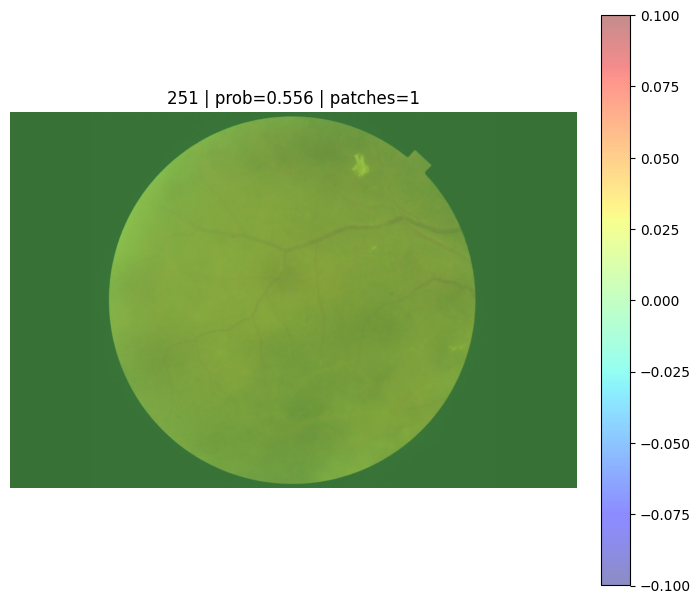

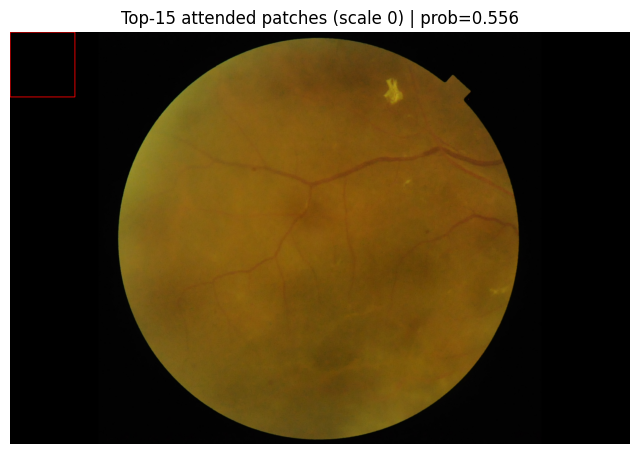

In [20]:
# ==========================================
# RANDOM RFMiD HEATMAP (PATCH-BASED) — FIXED + MORE MEANINGFUL
# - robust attrs reading (file attrs OR dataset attrs)
# - supports coords [N,2] or [N,3]
# - builds a GRID heatmap (one value per patch location) then upsamples (less blocky)
# - optional fundus mask (removes black border influence)
# - percentile contrast + gentler blur (prevents "flat green fog")
# ==========================================

import random
from pathlib import Path
import numpy as np
import pandas as pd
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import math

# ----------------------------
# PATHS (edit if needed)
# ----------------------------
WORK_DIR   = Path("/kaggle/working")
CKPT_PATH  = WORK_DIR / "checkpoints" / "best.pth"
LABELS_CSV = WORK_DIR / "rfmid_labels.csv"
FEAT_DIR   = WORK_DIR / "rfmid_extracted_features"
MS_DIR     = FEAT_DIR / "multi_scale"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

# ============================
# MODEL (with attention output)
# ============================

MASK_VAL = -1e4

class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super().__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        self.ln0 = nn.LayerNorm(dim_V) if ln else None
        self.ln1 = nn.LayerNorm(dim_V) if ln else None
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K, key_mask=None):
        Q, K, V = self.fc_q(Q), self.fc_k(K), self.fc_v(K)
        d = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(d, 2), 0)
        K_ = torch.cat(K.split(d, 2), 0)
        V_ = torch.cat(V.split(d, 2), 0)

        A = Q_.bmm(K_.transpose(1, 2)) / math.sqrt(self.dim_V)

        if key_mask is not None:
            km = key_mask.unsqueeze(1).expand(-1, A.size(1), -1)
            km = km.unsqueeze(1).expand(-1, self.num_heads, -1, -1)
            km = km.reshape(A.size(0), A.size(1), A.size(2))
            A = A.masked_fill(km == 0, MASK_VAL)

        A = F.softmax(A, dim=-1)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)

        if self.ln0 is not None:
            O = self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        if self.ln1 is not None:
            O = self.ln1(O)

        return O, A

class ISAB(nn.Module):
    def __init__(self, d_model, d_hidden, num_inds=20, heads=4):
        super().__init__()
        self.I = nn.Parameter(torch.randn(1, num_inds, d_hidden))
        nn.init.xavier_uniform_(self.I)
        self.mab0 = MAB(d_hidden, d_model, d_hidden, heads, ln=True)
        self.mab1 = MAB(d_model, d_hidden, d_hidden, heads, ln=True)

    def forward(self, X, key_mask=None):
        H, _ = self.mab0(self.I.repeat(X.size(0), 1, 1), X, key_mask)
        return self.mab1(X, H)[0]

class GatedAttn(nn.Module):
    def __init__(self, L, D):
        super().__init__()
        self.V = nn.Sequential(nn.Linear(L, D), nn.Tanh())
        self.U = nn.Sequential(nn.Linear(L, D), nn.Sigmoid())
        self.w = nn.Linear(D, 1)

    def forward(self, x, mask=None):
        scores = self.w(self.V(x) * self.U(x))
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(-1) == 0, MASK_VAL)
        A = F.softmax(scores, dim=1)
        return (A.transpose(1, 2) @ x).squeeze(1), A.squeeze(2)

class FPNMIL(nn.Module):
    def __init__(self, feat_dim=256, encoder_dim=256):
        super().__init__()
        self.encoders = nn.ModuleList([
            nn.Sequential(
                ISAB(feat_dim, encoder_dim),
                ISAB(encoder_dim, encoder_dim),
            ) for _ in range(2)
        ])
        self.aggregators = nn.ModuleList([GatedAttn(encoder_dim, encoder_dim) for _ in range(2)])
        self.scale_agg = GatedAttn(encoder_dim, encoder_dim)
        self.head = nn.Linear(encoder_dim, 1)

    def forward(self, x_list, return_attn=False):
        scale_embs = []
        patch_attn = []

        for i, x in enumerate(x_list):
            # x is [B,N,C,H,W] or [B,N,C] or [B,N,C?] (we convert to [B,N,C])
            if x.dim() == 5:
                x = x.mean(dim=(3, 4))  # GAP on H,W -> [B,N,C]

            h = self.encoders[i][0](x)
            h = self.encoders[i][1](h)
            emb, A = self.aggregators[i](h)  # A: [B,N]
            scale_embs.append(emb)
            patch_attn.append(A)

        x = torch.stack(scale_embs, dim=1)     # [B,S,C]
        emb, A_scale = self.scale_agg(x)       # A_scale: [B,S]
        logits = self.head(emb)                # [B,1]

        if return_attn:
            return logits, patch_attn, A_scale
        return logits

# ----------------------------
# Load model
# ----------------------------
ckpt = torch.load(CKPT_PATH, map_location="cpu", weights_only=False)
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt

model = FPNMIL().to(DEVICE)
model.load_state_dict(state, strict=False)
model.eval()
print("Model loaded from:", CKPT_PATH)

# ============================
# Helpers
# ============================

def to_bnc_from_saved_feats(x: torch.Tensor) -> torch.Tensor:
    """
    Saved feats are typically:
      - [N,C,H,W]  (fpn maps per patch)
    We need model input:
      - [B,N,C]
    """
    if x.dim() == 4:               # [N,C,H,W]
        x = x.mean(dim=(2, 3))     # [N,C]
        return x.unsqueeze(0)      # [1,N,C]
    if x.dim() == 2:               # [N,C]
        return x.unsqueeze(0)
    if x.dim() == 3:               # [B,N,C]
        return x
    raise ValueError(f"Unexpected feature shape: {tuple(x.shape)}")

def load_bag(case_id: str):
    bag_dir = MS_DIR / str(case_id) / str(case_id)
    if not bag_dir.exists():
        raise FileNotFoundError(f"Missing bag_dir: {bag_dir}")

    f1 = torch.load(bag_dir / "C4_patch_features.pt", map_location="cpu", weights_only=False)
    f2 = torch.load(bag_dir / "C5_patch_features.pt", map_location="cpu", weights_only=False)

    with h5py.File(bag_dir / "info_patches.h5", "r") as f:
        dset = f["coords"]
        coords = np.array(dset)

        def get_attr(name, default=None):
            if name in dset.attrs:
                return dset.attrs[name]
            if name in f.attrs:
                return f.attrs[name]
            return default

        patch_size = int(get_attr("patch_size", 224))
        stride     = int(get_attr("stride", patch_size))

        # if extractor saved original img size in attrs, use it; else we’ll fallback to the real image size later
        img_h = int(get_attr("img_height", 0))
        img_w = int(get_attr("img_width", 0))

    return f1, f2, coords, patch_size, stride, img_h, img_w, bag_dir

def coords_to_xy(coords: np.ndarray):
    """
    Supports coords:
      - [N,2] = (y,x)
      - [N,3] = (z,y,x)
    Returns (ys,xs) as int32 arrays.
    """
    coords = np.asarray(coords)
    if coords.ndim != 2 or coords.shape[1] not in (2, 3):
        raise ValueError(f"Unexpected coords shape: {coords.shape}")

    if coords.shape[1] == 2:
        ys = coords[:, 0]
        xs = coords[:, 1]
    else:
        ys = coords[:, 1]
        xs = coords[:, 2]

    return ys.astype(np.int32), xs.astype(np.int32)

def build_grid_heatmap(ys, xs, attn):
    """
    Build a low-res grid heatmap (one value per patch start location),
    then we upsample to image size. This avoids painting big blocks.
    """
    ys = np.asarray(ys).astype(np.int32)
    xs = np.asarray(xs).astype(np.int32)
    attn = np.asarray(attn).astype(np.float32)

    uy = np.unique(ys)
    ux = np.unique(xs)
    y2i = {y: i for i, y in enumerate(uy)}
    x2i = {x: i for i, x in enumerate(ux)}

    grid = np.zeros((len(uy), len(ux)), dtype=np.float32)
    cnt  = np.zeros_like(grid)

    for y, x, a in zip(ys, xs, attn):
        grid[y2i[int(y)], x2i[int(x)]] += float(a)
        cnt[y2i[int(y)], x2i[int(x)]]  += 1.0

    grid = grid / np.maximum(cnt, 1e-6)

    # normalize grid to [0,1]
    grid = (grid - grid.min()) / (grid.max() - grid.min() + 1e-8)
    return grid

def robust_contrast_01(x, lo=5, hi=99):
    """
    Percentile-based contrast stretch to avoid "flat heatmap".
    """
    x = x.astype(np.float32)
    a, b = np.percentile(x, (lo, hi))
    x = np.clip((x - a) / (b - a + 1e-8), 0, 1)
    return x

def fundus_mask(img_rgb, thr=10):
    """
    Crude mask to remove black borders:
    img_rgb in [0,1], shape [H,W,3]
    """
    gray = (img_rgb.mean(axis=2) * 255).astype(np.uint8)
    _, m = cv2.threshold(gray, thr, 1, cv2.THRESH_BINARY)
    m = cv2.medianBlur((m * 255).astype(np.uint8), 21)
    m = (m > 0).astype(np.float32)
    return m

# ============================
# RANDOM SAMPLE
# ============================

df = pd.read_csv(LABELS_CSV)
df["image_id"] = df["image_id"].astype(str)

# keep only ids that have extracted features
valid_ids = [iid for iid in df["image_id"].tolist() if (MS_DIR / iid / iid).exists()]
if len(valid_ids) == 0:
    raise RuntimeError(f"No valid ids found under {MS_DIR}. Check your feature extraction output.")

image_id = random.choice(valid_ids)
row = df[df["image_id"] == image_id].iloc[0]
print("Random image_id:", image_id)

# ----------------------------
# Run model
# ----------------------------
f1, f2, coords, patch_size, stride, img_h, img_w, bag_dir = load_bag(image_id)

x_list = [
    to_bnc_from_saved_feats(f1).float().to(DEVICE),
    to_bnc_from_saved_feats(f2).float().to(DEVICE),
]

with torch.no_grad():
    logits, patch_attn_list, scale_attn = model(x_list, return_attn=True)
    prob = torch.sigmoid(logits).item()
    A = patch_attn_list[0].squeeze(0).detach().cpu().numpy()  # scale 0 attention: [N]

print(f"Predicted prob: {prob:.4f}")
print("Attn stats (min/mean/max/std):", float(A.min()), float(A.mean()), float(A.max()), float(A.std()))
print("Using bag:", bag_dir)

# ----------------------------
# Load original image
# ----------------------------
img = Image.open(row["img_path"]).convert("RGB")
img = np.asarray(img).astype(np.float32) / 255.0
H_img, W_img = img.shape[:2]

# If extractor didn't store img_h/img_w, fallback to actual image size
if img_h == 0 or img_w == 0:
    img_h, img_w = H_img, W_img

# ----------------------------
# Build a grid heatmap (better than painting full blocks)
# ----------------------------
ys, xs = coords_to_xy(coords)

grid = build_grid_heatmap(ys, xs, A)  # [Gy,Gx] in [0,1]
heat = cv2.resize(grid, (W_img, H_img), interpolation=cv2.INTER_CUBIC)

# gentle blur (NOT 25)
heat = cv2.GaussianBlur(heat, (0, 0), sigmaX=5, sigmaY=5)

# robust contrast
heat = robust_contrast_01(heat, lo=5, hi=99)

# optional: mask outside fundus
m = fundus_mask(img, thr=10)
heat = heat * m
heat = robust_contrast_01(heat, lo=5, hi=99)

# ----------------------------
# Plot (overlay + top-k boxes)
# ----------------------------
TOPK = 15
top_idx = np.argsort(A)[-TOPK:]

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.imshow(heat, cmap="jet", alpha=0.45)
plt.title(f"{image_id} | prob={prob:.3f} | patches={len(A)}")
plt.axis("off")
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()

# Also show top-k patch boxes (often more interpretable)
img_boxes = (img * 255).astype(np.uint8).copy()
ys_i, xs_i = ys.astype(int), xs.astype(int)
for i in top_idx:
    y, x = int(ys_i[i]), int(xs_i[i])
    cv2.rectangle(img_boxes, (x, y), (x + int(patch_size), y + int(patch_size)), (255, 0, 0), 2)

plt.figure(figsize=(8, 8))
plt.imshow(img_boxes)
plt.title(f"Top-{TOPK} attended patches (scale 0) | prob={prob:.3f}")
plt.axis("off")
plt.show()